# Finding Optimal Locations for Dark Stores for quick commerce

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from tqdm import tqdm
import re

In [ ]:
np.random.seed(0)

# uniformly distributed points
points=100*np.random.random((100, 2))


## Setting up locations of customers on a map with areas of different traffic levels

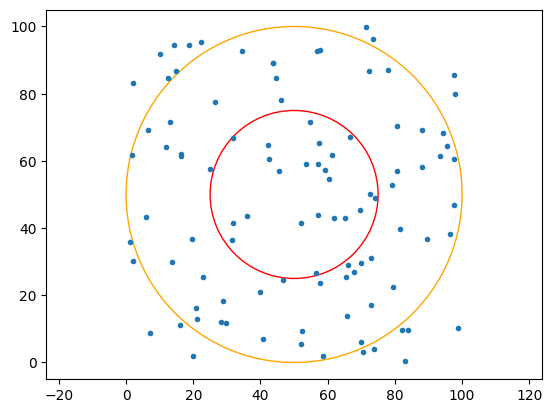

In [3]:
def multiplier(point):
    centre= [50,50]
    dist= ((point[0]-centre[0])**2 + (point[1]-centre[1])**2)**0.5
    j=0
    while j<dist:
        j+=25
    return max(2.5-j/50, 1)



traffic_data={}
for i in points:
    traffic_data[str(i)]=multiplier(i)

circle2 = plt.Circle((50, 50), 50, fill=False, color='orange')
circle1 = plt.Circle((50, 50), 25, fill=False, color='red')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)

points_t=points.T
plt.plot(points_t[0], points_t[1], '.');

plt.axis('equal')
plt.show()

## Defining distance and travel time functions

In [4]:
k=30# maximum distance 'k'

def dist(point1, point2):
    distance=((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)**0.5
    return distance

def path_time(point1, point2):

    # case 1 (path not possible between points, since distance is too big)
    if np.abs(traffic_data[str(point1)]-traffic_data[str(point2)])==1:
        return 30*2

    c=min(traffic_data[str(point1)], traffic_data[str(point2)])

    # case 2 (both points lie in the innermost region)
    if c==2:
        return dist(point1, point2)*2

    # case 3 (points lie in middle or outer region)
    elif c==1.5:
        r=25
    elif c==1:
        r=50


    # FIND SOLUTION IN Y INSTEAD OF X TO AVOID INFINITY SLOPE ERROR
    if abs(point1[0]-point2[0])>=10**(-3.5):
        m=(point1[1]-point2[1])/(point1[0]-point2[0])

# SLOPE IS INFINITE
    else:
        D=r**2-(point1[0]-50)**2

        # case 1 (path does not intersect any circle, so return the distance multiplied by the weight)
        if D<=0:
            return (point1[1]-point2[1])*c

        # possible intersection
        y1=50+(r**2 - (point1[0]-50)**2)**0.5
        y2=50-(r**2 - (point1[0]-50)**2)**0.5

        if traffic_data[str(point1)]==traffic_data[str(point2)]:

            # case 2 (path does not intersect any circle, so return the distance multiplied by the weight)
            if (y1>=max(point1[1], point2[1]) or y1<=min(point1[1], point2[1])) and (y2>=max(point1[1], point2[1]) or y2<=min(point1[1], point2[1])):
                return dist(point1, point2)*c

            # case 3 (path intersects the circle at 2 points)
            else:
                d1= np.abs(y2-y1)
                return (np.abs(point1[1]-point2[1])-d1)*c + d1*(c+0.5)

        else:
            if y1<=max(point1[1], point2[1]) and y1>=min(point1[1], point2[1]):
                return abs(point1[1]-y1)*traffic_data[str(point1)] + abs(point2[1]-y1)*traffic_data[str(point2)]
            else:
                return abs(point1[1]-y2)*traffic_data[str(point1)] + abs(point2[1]-y2)*traffic_data[str(point2)]


    p=m*point1[0]+50-point1[1]
    D=(50+m*p)**2 - (1+m**2)*(p**2+50**2-r**2)




    # case 1 (path does not intersect any circle, so return the distance multiplied by the weight)
    if D<=0:
        return dist(point1, point2)*c

    # possible intersection

    x1= (50+m*p + D**0.5)/(1+m**2)
    x2= (50+m*p - D**0.5)/(1+m**2)

    # points lie in the same traffic region
    if traffic_data[str(point1)]==traffic_data[str(point2)]:

        # case 2 (path does not intersect any circle, so return the distance multiplied by the weight)
        if (x1>=max(point1[0], point2[0]) or x1<=min(point1[0], point2[0])) and (x2>=max(point1[0], point2[0]) or x2<=min(point1[0], point2[0])):
            return dist(point1, point2)*c

        # case 3 (path intersects the circle at 2 points)
        else:
            d1= dist([x1,point1[1]+m*(x1-point1[0])], [x2,point1[1]+m*(x2-point1[0])] )
            return (dist(point1, point2)-d1)*c + d1*(c+0.5)

    # points lie in adjacent traffic sections, so 1 intersection
    # case 4 (path intersects the circle at 1 point)
    else:
        if x1<=max(point1[0], point2[0]) and x1>=min(point1[0], point2[0]):
            y=point1[1]+m*(x1-point1[0])
            x=x1
        elif x2<=max(point1[0], point2[0]) and x2>=min(point1[0], point2[0]):
            y=point1[1]+m*(x2-point1[0])
            x=x2
        return dist([x,y], point1)*traffic_data[str(point1)] + dist([x,y], point2)*traffic_data[str(point2)]


## Main part of the code, including the optimization function

In [5]:
def add_origin(route, points, radius=k):
    origin = route[0] # the origin for every iteration has been added to the front of the list,
                      # so it is being extracted here
    new_path = [origin] # origin is the first location of the new_path
    route = route[1:]
    route_time = 0 # initial time for route of first delivery man

    while len(route) > 0: # while there are still places left on the map to deliver to
        
        point_time=path_time(points[new_path[-1]], points[route[0]]) # distance of next point from last point in new route
        route_time +=point_time # path time

        if route_time > radius:
            new_path.append(origin) # start new delivery man
            route_time = 0
        else:
            new_path.append(route[0])
            route = route[1:]

    new_path.append(origin)
    return new_path


In [6]:
def two_opt(route, points):
    n = len(route) 
    improvement = True

    while improvement:
        improvement = False
        for i in range(1, n - 2):
            for j in range(i + 1, n):
                new_route = route.copy()
                new_route[i:j] = route[j - 1 : i - 1 : -1]
                new_distance = calculate_distance(new_route, points) 
                # here the new_distance is calculated
                # this invokes the calculate_distance function, which in turn invokes the add_origin function
                # while calculating the distance. hence the total path length is optimized, including return 
                # visits to the origin, when the journey length is greater than 'k' kms.

                if new_distance < calculate_distance(route, points): 
                    # both the new and old distances take origin visits into account
                    route = new_route
                    improvement = True

        return route

    
def calculate_distance(route, points, go_origin=True): 
    # the go_origin parameter dictates whether we invoke the add_origin function or not
    # we will not invoke it only in the case where we have to find the total path length, since origin visits are
    # already included as part of the final path.
    route_time = 0
    if go_origin==True:
        route=add_origin(route, points)
    n = len(route)

    for i in range(n - 1):
        route_time += path_time(points[route[i]], points[route[i+1]])
    route_time += path_time(points[route[n-1]], points[route[0]]) 

    return route_time

## Defining function for points within reachable areas, and maximum deliveries

In [7]:
def points_in_radius(points, origin, radius=k): # function to find the points within 'k' minutes from origin
    in_radius=[]
    for i in points:
        if path_time(origin, i)<=radius:
            in_radius.append(list(i))
    return (in_radius)

def total_deliveries(optimized_route, points, n=5):
    deliveries=[]
    new_delivery=[]
    for i in optimized_route[1:]:
        if i==0:
            deliveries.append([len(new_delivery), new_delivery])
            new_delivery=[]
        else:
            new_delivery.append(i)
            
    dels=sorted(deliveries)[::-1][:n]
    
    total_dels=0
    final_path=[0]
    for i in dels:
        final_path+=i[1]+[0]
        total_dels+=i[0]
    
    return points[final_path], calculate_distance(final_path, points, go_origin=False), total_dels


## Dummy run for the code

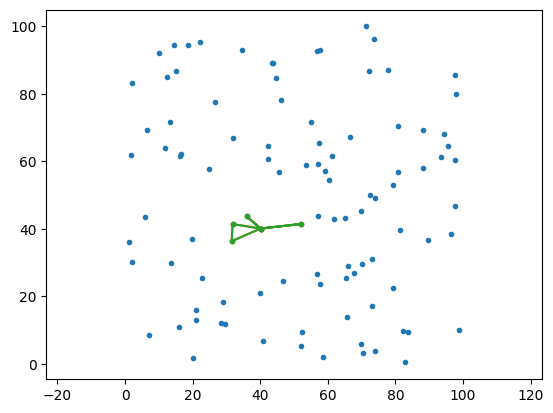

In [8]:
origin=np.array([40.1,40.1])
traffic_data[str(origin)]=multiplier(origin)
p= np.array([origin]+points_in_radius(points, origin))
initial_route = [i for i in range(len(p))]

optimized_route = add_origin(two_opt(initial_route, p), p)
pt=p[optimized_route]

path_final, time, dels=total_deliveries(optimized_route, p, n=5)
plt.plot(points_t[0], points_t[1], '.');
plt.plot(pt.T[0], pt.T[1], '.-');
plt.plot(path_final.T[0], path_final.T[1], '.-');
# plt.plot(90.1, 90.1,'o');

circle2 = plt.Circle((50, 50), 50, fill=False, color='orange')
circle1 = plt.Circle((50, 50), 25, fill=False, color='red')
# plt.gca().add_patch(circle1)
# plt.gca().add_patch(circle2)


plt.axis('equal')
plt.show()

## Function for running the code on a full map

In [9]:
def find_location(traffic_data, points, grid_divisions, grid):
    customers={}

    h0,k0,l0=grid # centre of grid and length of grid

    for i in tqdm(range(grid_divisions+1)):
        for j in range(grid_divisions+1):
            origin=np.array([i* l0/grid_divisions + h0-l0/2 +(0.1**5) , j* l0/grid_divisions + k0-l0/2 +(0.1**5)])
            traffic_data[str(origin)]=multiplier(origin)
            zone= np.array([origin]+points_in_radius(points, origin))

            initial_route = [i for i in range(len(zone))]

            optimized_route = add_origin(two_opt(initial_route, zone), zone)
            pt, path_time, total_dels=total_deliveries(optimized_route, zone, n=5)
            customers[str([origin[0],origin[1]])]=[total_dels, -path_time]

    return customers



## Main function 

In [14]:
def traversal(traffic_data,points):

    locations = find_location(traffic_data, points, 10, [50,50,100])
    locations = sorted(locations, key=locations.get)[::-1]
    
    top_4_locations=[]
    for key in locations:
        if len(top_4_locations)==2:
            break
        top_4_locations.append([float(i) for i in key[1:-1].split(',')])

    final_locs={}
    for i in top_4_locations:
        locations=find_location(traffic_data, points, 5, [i[0],i[1],20])
        final_locs.update(locations)

    warehouse_location=max(zip(final_locs.values(), final_locs.keys()))[1]
    warehouse_location=np.array([float(i)+0.1**5 for i in warehouse_location[1:-1].split(',')])

    traffic_data[str(warehouse_location)]=multiplier(warehouse_location)
    zone= np.array([warehouse_location]+points_in_radius(points, warehouse_location))

    initial_route = [i for i in range(len(zone))]

    optimized_route = add_origin(two_opt(initial_route, zone), zone)
    pt, path_time, total_dels=total_deliveries(optimized_route, zone, n=5)
    

    
    return warehouse_location, pt

In [15]:
import time

In [16]:
np.random.seed(0)

mean = 50  
std_dev = 20
x = np.random.normal(mean, std_dev, 50)
y = np.random.normal(mean, std_dev, 50)

points=np.array([x,y]).T

traffic_data={}
for i in points:
    traffic_data[str(i)]=multiplier(i)

    
t1=time.time()
warehouse_location1, customers1 = traversal(traffic_data,points)
print("TIME REQ",time.time()-t1)


100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.45s/it]

TIME REQ 23.51661491394043


In [17]:
np.random.seed(0)

mean = 50  
std_dev = 20
x = np.random.normal(mean, std_dev, 100)
y = np.random.normal(mean, std_dev, 100)

points=np.array([x,y]).T

traffic_data={}
for i in points:
    traffic_data[str(i)]=multiplier(i)

    
t1=time.time()
warehouse_location1, customers1 = traversal(traffic_data,points)
print("TIME REQ",time.time()-t1)


100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.02s/it]


TIME REQ 136.5348699092865


In [18]:
np.random.seed(0)

mean = 50  
std_dev = 20
x = np.random.normal(mean, std_dev, 200)
y = np.random.normal(mean, std_dev, 200)

points=np.array([x,y]).T

traffic_data={}
for i in points:
    traffic_data[str(i)]=multiplier(i)

    
t1=time.time()
warehouse_location1, customers1 = traversal(traffic_data,points)
print("TIME REQ",time.time()-t1)


 17%|███████▎                                    | 1/6 [02:47<13:58, 167.75s/it]


KeyboardInterrupt: 

In [ ]:
warehouse_location1, customers1 = traversal(traffic_data,points)


In [44]:

list_of_points=set(tuple(i) for i in points)
points_to_remove = set(tuple(i) for i in customers1)
remaining_points = [point for point in list_of_points if point not in points_to_remove]
remaining_points = np.array(remaining_points)


In [45]:
warehouse_location2, customers2 = traversal(traffic_data, remaining_points)


100%|███████████████████████████████████████████| 11/11 [00:28<00:00,  2.55s/it]


['[20.00001, 80.00001]', '[10.00001, 80.00001]', '[30.00001, 20.00001]', '[90.00001, 70.00001]', '[20.00001, 20.00001]', '[10.00001, 90.00001]', '[10.00001, 70.00001]', '[90.00001, 60.00001]', '[100.00001, 70.00001]', '[30.00001, 10.00001]', '[70.00001, 50.00001]', '[60.00001, 50.00001]', '[20.00001, 90.00001]', '[30.00001, 90.00001]', '[30.00001, 100.00001]', '[10.00001, 10.00001]', '[80.00001, 40.00001]', '[20.00001, 10.00001]', '[80.00001, 60.00001]', '[1.0000000000000003e-05, 70.00001]', '[1.0000000000000003e-05, 80.00001]', '[60.00001, 60.00001]', '[40.00001, 90.00001]', '[1.0000000000000003e-05, 90.00001]', '[50.00001, 60.00001]', '[20.00001, 1.0000000000000003e-05]', '[30.00001, 1.0000000000000003e-05]', '[80.00001, 50.00001]', '[100.00001, 60.00001]', '[40.00001, 10.00001]', '[40.00001, 100.00001]', '[20.00001, 70.00001]', '[60.00001, 90.00001]', '[50.00001, 50.00001]', '[100.00001, 80.00001]', '[60.00001, 80.00001]', '[80.00001, 80.00001]', '[30.00001, 80.00001]', '[30.00001, 

100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.27s/it]


In [46]:
list_of_points=set(tuple(i) for i in remaining_points)
points_to_remove = set(tuple(i) for i in customers2)
remaining_points2 = [point for point in list_of_points if point not in points_to_remove]
remaining_points2 = np.array(remaining_points2)


In [47]:
warehouse_location3, customers3 = traversal(traffic_data, remaining_points2)


100%|███████████████████████████████████████████| 11/11 [00:20<00:00,  1.87s/it]


['[20.00001, 20.00001]', '[30.00001, 20.00001]', '[90.00001, 70.00001]', '[90.00001, 60.00001]', '[100.00001, 70.00001]', '[30.00001, 10.00001]', '[70.00001, 50.00001]', '[60.00001, 50.00001]', '[10.00001, 10.00001]', '[30.00001, 30.00001]', '[80.00001, 40.00001]', '[20.00001, 10.00001]', '[80.00001, 60.00001]', '[60.00001, 60.00001]', '[50.00001, 60.00001]', '[20.00001, 1.0000000000000003e-05]', '[30.00001, 1.0000000000000003e-05]', '[80.00001, 50.00001]', '[100.00001, 60.00001]', '[40.00001, 10.00001]', '[60.00001, 90.00001]', '[50.00001, 50.00001]', '[100.00001, 80.00001]', '[60.00001, 80.00001]', '[80.00001, 80.00001]', '[40.00001, 90.00001]', '[70.00001, 40.00001]', '[100.00001, 50.00001]', '[90.00001, 50.00001]', '[40.00001, 20.00001]', '[70.00001, 60.00001]', '[60.00001, 70.00001]', '[90.00001, 80.00001]', '[90.00001, 90.00001]', '[1.0000000000000003e-05, 10.00001]', '[70.00001, 80.00001]', '[40.00001, 80.00001]', '[1.0000000000000003e-05, 20.00001]', '[10.00001, 20.00001]', '[2

100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.68s/it]


In [48]:
list_of_points=set(tuple(i) for i in remaining_points2)
points_to_remove = set(tuple(i) for i in customers3)
remaining_points3 = [point for point in list_of_points if point not in points_to_remove]
remaining_points3 = np.array(remaining_points3)


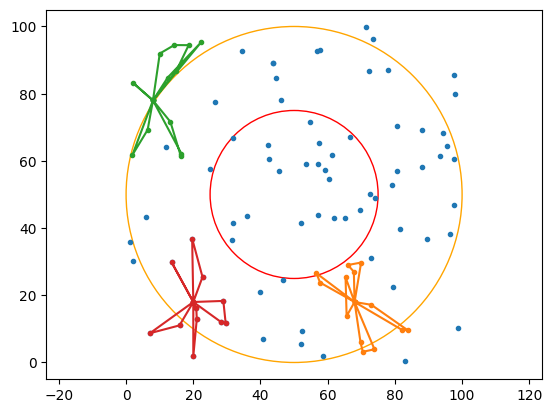

In [49]:
plt.plot(remaining_points2.T[0], remaining_points2.T[1], '.');
# plt.plot(points.T[0], points.T[1], '.');
plt.plot(customers1.T[0], customers1.T[1], '.-');
plt.plot(customers2.T[0], customers2.T[1], '.-');
plt.plot(customers3.T[0], customers3.T[1], '.-');


circle2 = plt.Circle((50, 50), 50, fill=False, color='orange')
circle1 = plt.Circle((50, 50), 25, fill=False, color='red')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)


plt.axis('equal')
plt.show()

In [1]:
# case 1 : constant travel times

In [2]:
# case 2 : different travel times

In [3]:
# case 3 : different travel times with gaussian dist